# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [72]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [73]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [75]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [108]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [149]:
channels = ["ele", "mu"]
samples = [
    "QCD",
    "Data",
    "DYJets",
    "WJetsLNu",
]

years = ["2016", "2016APV", "2017", "2018"]
years = ["2017"]

samples_dir = {
    "2018": "../eos/May16_fakes_2018",
    "2017": "../eos/May16_fakes_2017",
#     "2017": "../eos/May27_fakes_mva_2017",
#     "2017": "../eos/May27_fakes_cutbased_2017",    
    "2016": "../eos/May16_fakes_2016",
    "2016APV": "../eos/May16_fakes_2016APV",    
}

In [150]:
from make_stacked_hists_fake import make_events_dict

events_dict = {}
for year in years:
    
    out = make_events_dict([year], channels, samples_dir[year], samples)
    events_dict = {**events_dict, **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14 events
INFO:root:tot event weight 14.653080235397406 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2580 events
INFO:root:tot event weight 97.24040405668134 

INFO:root:Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1529 events
INFO:root:tot event weight 17.41594934712444 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1951 events
INFO:root:tot

INFO:root:---> Using already stored event weight
INFO:root:Will fill the DYJets dataframe with the remaining 851 events
INFO:root:tot event weight 0.378993283625689 

INFO:root:Finding WJetsToQQ_HT-200to400 samples and should combine them under WJetsLNu
INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-100To250 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Will fill the DYJets dataframe with the remaining 6590 events
INFO:root:tot event weight 354.995754479448 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 7589 events
INFO:root:tot event weight 7589.0 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 3384 events
INFO:root:tot event weight 3384.0 

INFO:root:Finding DYJetsToLL_LHE

In [151]:
events_dict["2017"]["ele"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'Data', 'QCD'])

# Stacked hists

In [141]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [142]:
for key in events_dict["2017"]["ele"]["Data"].keys():
    print(key)

N_tight_lep
N_loose_lep
tight_lep1_pt
tight_lep1_eta
tight_lep2_pt
tight_lep2_eta
mll_tight
loose_lep1_pt
loose_lep1_eta
loose_lep2_pt
loose_lep2_eta
mll_loose
met_pt
NumFatjets
lep_fj_dr
fj_pt
fj_eta
fj_phi
mT_tight1
mT_loose1
event_weight


In [152]:
vars_to_plot = [
#     "N_tight_lep",
#     "N_loose_lep",
    "tight_lep1_pt",
    "tight_lep1_eta",
#     "tight_lep2_pt",
#     "tight_lep2_eta",
#     "mll_tight",
    "loose_lep1_pt",
    "loose_lep1_eta",
#     "loose_lep2_pt",
#     "loose_lep2_eta",
#     "mll_loose",
    "met_pt",
#     "mT_loose1",
#     "mT_tight1",
]

samples_to_plot = [
    "QCD",
    "Data",
    "DYJets",
    "WJetsLNu",    
]

In [153]:
import utils

axis_dict = {
    "mll_loose": hist2.axis.Regular(40, 30, 450, name="var", label=r"Zmass [GeV]", overflow=True),
    "fj_pt": hist2.axis.Regular(30, 250, 600, name="var", label=r"Higgs candidate jet $p_T$ [GeV]", overflow=True),

    "loose_lep1_pt": hist2.axis.Regular(40, 30, 400, name="var", label=r"First loose Lepton $p_T$ [GeV]", overflow=True),    
    "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First loose Lepton |$\eta$|", overflow=True),    
    
    "loose_lep2_pt": hist2.axis.Regular(40, 30, 200, name="var", label=r"Second loose Lepton $p_T$ [GeV]", overflow=True),
    "loose_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second loose Lepton |$\eta$|", overflow=True),

    "tight_lep1_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"First tight Lepton $p_T$ [GeV]", overflow=True),    
    "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First tight Lepton |$\eta$|", overflow=True),    
    
    "tight_lep2_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"Second tight Lepton $p_T$ [GeV]", overflow=True),
    "tight_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second tight Lepton |$\eta$|", overflow=True),
    
    "met_pt": hist2.axis.Regular(40, 0, 100, name="var", label=r"MET [GeV]", overflow=True),
    
    
    "mT_loose1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using loose lepton)", overflow=True),
    "mT_tight1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using tight lepton) [GeV]", overflow=True),
    
}

presel = {
    "fake": f"loose_lep1_pt>0",   # dummy
}

channels = ["ele", "mu"]
channels = ["ele"]
years = ["2016", "2016APV", "2017", "2018"]
years = ["2017"]

# fill histograms
hists = {}

for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        axis_dict[var],
        storage=hist2.storage.Weight(),            
    )        

    for sample in samples_to_plot:
        for year in years:
            for ch in channels:

                df = events_dict[year][ch][sample]
                
                for region in presel:
                    df = df.query(presel[region])

                if "eta" in var:
                    x = np.absolute(df[var])
                else:
                    x = df[var]
                w = df["event_weight"]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     

for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot tight_lep1_pt histogram
Will plot tight_lep1_eta histogram
Will plot loose_lep1_pt histogram
Will plot loose_lep1_eta histogram
Will plot met_pt histogram


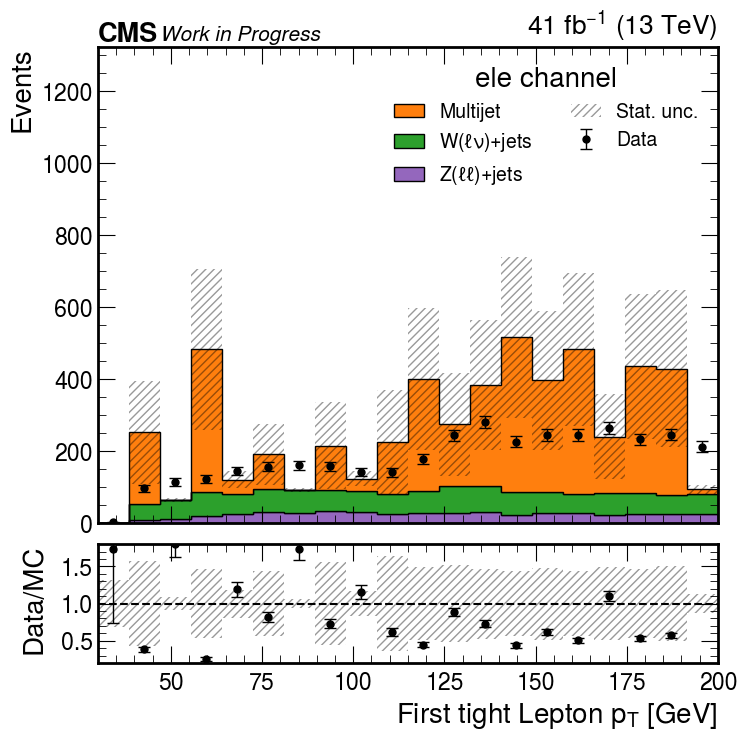

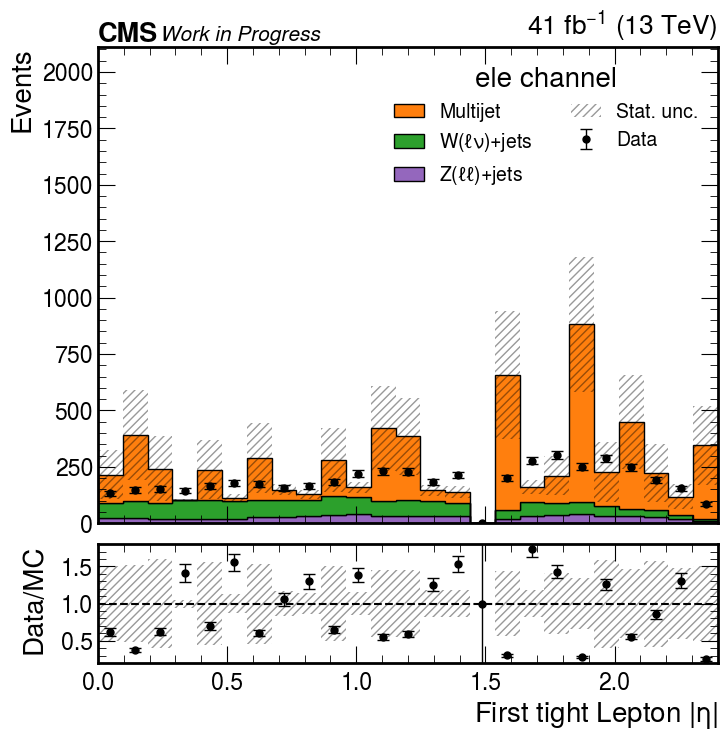

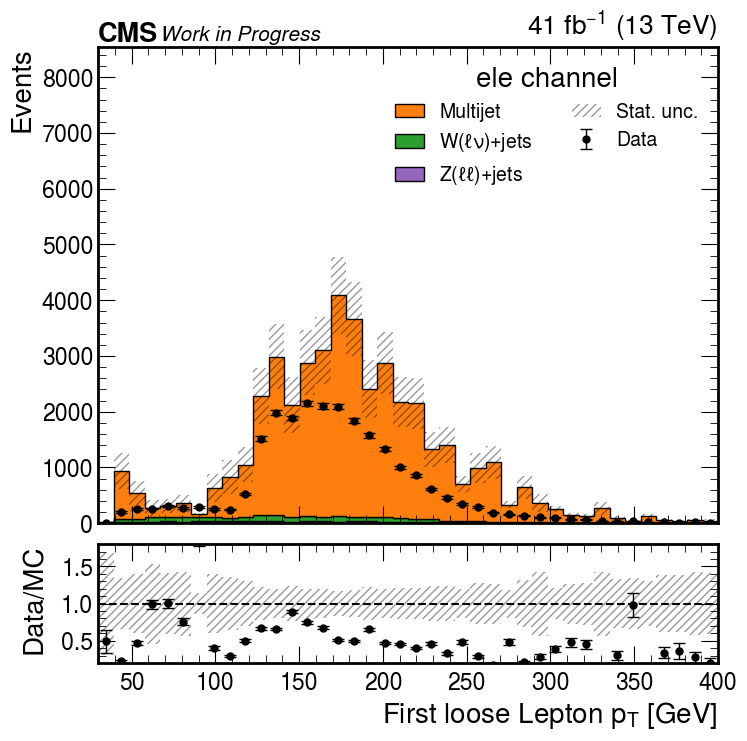

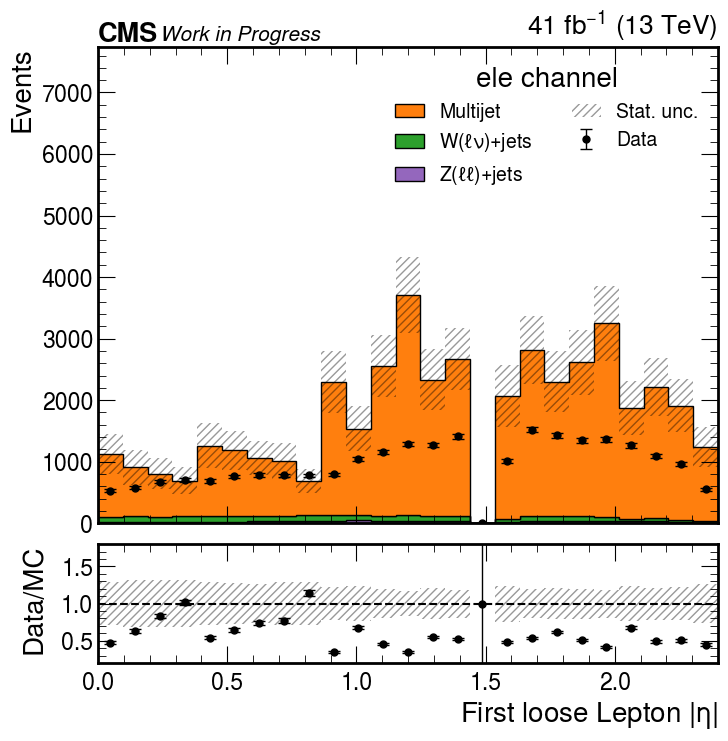

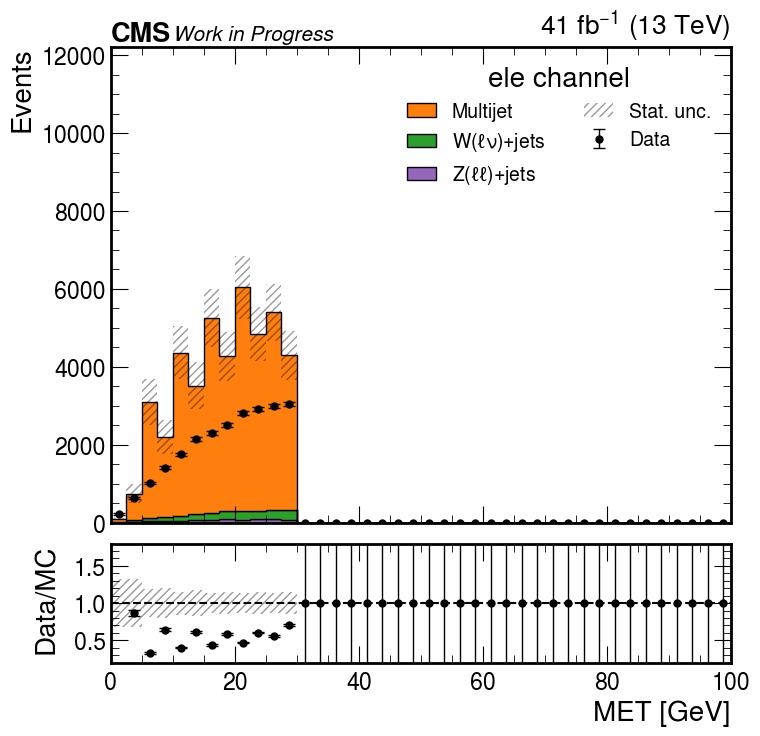

In [154]:
if len(channels) == 2:
    text_ = "Semi-leptonic channel"
else:
    text_ = f"{ch} channel"

plt.rcParams.update({"font.size": 20})
add_data = True
add_soverb = False
    
from utils import plot_hists as plot_hists

PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=1,
            outpath=PATH,
            text_=text_,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=False,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )

In [117]:
def set_im_title(year, ch, region):
    if region != "SF":
        region += " rate"
    if ch == "ele":
        return f"Electron {region} {year}"
    else:
        return f"Muon {region} {year}"
    
def plot_matrix(M, region, channels, num=False, den=False):
    for ch in channels:
        fig, ax = plt.subplots(figsize=(10,10))

        if (num is False) and (den==False):
            im = ax.imshow(M[ch], vmax=1, vmin=0)#, cmap='hot', interpolation='nearest')
        else:
            im = ax.imshow(M[ch], vmin=0)#, cmap='hot', interpolation='nearest')

        ax.set_xticks(ticks=np.arange(-0.5, (len(etabinning)-1), 1), labels=np.round(etabinning,2))
        ax.set_yticks(ticks=np.arange(-0.5, (len(ptbinning[ch])-1), 1), labels=np.round(ptbinning[ch],2))

        ax.tick_params(axis='x', which='major', pad=8)
        ax.tick_params(axis='y', which='major', pad=8)

        # Loop over data dimensions and create text annotations.
        for i in range(len(ptbinning[ch])-1):
            for j in range(len(etabinning)-1):
                text = ax.text(j, i, np.round(M[ch][i, j],2), ha="center", va="center")#, color="w")

        ax.set_xlabel(r"$\eta$")            
        ax.set_ylabel(r"$p_T$")
        
        plt.colorbar(im, shrink=0.8)
#         plt.tight_layout()
        
        if num:
            ax.set_title(f"{ch} {year}: " + r"$tight_{Data}$", pad=20)
            if region=="SF":
                ax.set_title(f"{ch} {year}: " + r"$loose_{Data}$", pad=20)
            plt.savefig(f"{PATH}/{year}_{ch}_{region}_num.pdf")            
        elif den:
            ax.set_title(f"{ch} {year}: " + r"$loose_{Data}$", pad=20)            
            if region=="SF":
                ax.set_title(f"{ch} {year}: " + r"$loose_{DY}$", pad=20)            
            plt.savefig(f"{PATH}/{year}_{ch}_{region}_den.pdf")            
        else:
            ax.set_title(set_im_title(year,ch,region), pad=20)
            plt.savefig(f"{PATH}/{year}_{ch}_{region}.pdf")    
            
PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/"            

# Fake rate extraction (w/o SF)

In [118]:
years

['2017']

In [119]:
channels = [
    "ele",
    "mu"
]

ptbinning = {}
ptbinning["ele"] = [2000, 300, 250, 230, 210, 180, 150, 120, 90, 60, 30]
ptbinning["mu"] = [2000, 200, 120, 90, 60, 30]

etabinning = np.round(np.linspace(0, 2.4, 6), 2)
etabinning = [0, 0.5, 1, 1.5, 2, 2.5]

FR = {}
for year in years:
    FR[year] = {}
    for ch in channels:
        FR[year][ch] = np.zeros((len(ptbinning[ch])-1,len(etabinning)-1))
        print(year, ch, FR[year][ch].shape)

2017 ele (10, 5)
2017 mu (5, 5)


In [120]:
for year in years:
    for ch in channels:
        print(f"{year}, {ch} channel:")    

        df = events_dict[year][ch]

        for i in range(len(ptbinning[ch])-1):
            high_pt = ptbinning[ch][i]
            low_pt = ptbinning[ch][i+1]

            msk_pt = (df["Data"]["loose_lep1_pt"] >= low_pt) & (df["Data"]["loose_lep1_pt"] < high_pt)
            msk_pt_wjets = (df["WJetsLNu"]["loose_lep1_pt"] >= low_pt) & (df["WJetsLNu"]["loose_lep1_pt"] < high_pt)
            msk_pt_dyjets = (df["DYJets"]["loose_lep1_pt"] >= low_pt) & (df["DYJets"]["loose_lep1_pt"] < high_pt)

            print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")

            for j in range(len(etabinning)-1):        

                low_eta = etabinning[j]
                high_eta = etabinning[j+1]

                # get data tight/loose ratio                
                msk_eta = (abs(df["Data"]["loose_lep1_eta"]) >= low_eta) & (abs(df["Data"]["loose_lep1_eta"]) < high_eta)
                msk_Nt1 = df["Data"]["N_tight_lep"]==1
                msk_Nt0 = df["Data"]["N_loose_lep"]==1

                tight = len(df["Data"][msk_Nt1 & msk_pt & msk_eta])
                loose = len(df["Data"][msk_Nt0 & msk_pt & msk_eta])            

                # get the EWK corr WJets
                msk_eta_wjets = (abs(df["WJetsLNu"]["loose_lep1_eta"]) >= low_eta) & (abs(df["WJetsLNu"]["loose_lep1_eta"]) < high_eta)
                msk_Nt1_wjets = df["WJetsLNu"]["N_tight_lep"]==1      
                msk_Nt0_wjets = df["WJetsLNu"]["N_loose_lep"]==1

                tight_wjets = df["WJetsLNu"]["event_weight"][msk_Nt1_wjets & msk_pt_wjets & msk_eta_wjets].sum()
                loose_wjets = df["WJetsLNu"]["event_weight"][msk_Nt0_wjets & msk_pt_wjets & msk_eta_wjets].sum()

                # get the EWK corr dyjets
                msk_eta_dyjets = (abs(df["DYJets"]["loose_lep1_eta"]) >= low_eta) & (abs(df["DYJets"]["loose_lep1_eta"]) < high_eta)
                msk_Nt1_dyjets = df["DYJets"]["N_tight_lep"]==1      
                msk_Nt0_dyjets = df["DYJets"]["N_loose_lep"]==1

                tight_dyjets = df["DYJets"]["event_weight"][msk_Nt1_dyjets & msk_pt_dyjets & msk_eta_dyjets].sum()
                loose_dyjets = df["DYJets"]["event_weight"][msk_Nt0_dyjets & msk_pt_dyjets & msk_eta_dyjets].sum()

                # get the SF                
                SF = 0.9
                FR[year][ch][i,j] = (tight - SF*(tight_wjets+tight_dyjets))/(loose-SF*(loose_wjets+loose_dyjets))

        print("----------------------------")

2017, ele channel:
   ptbin (300.00, 2000.00)
   ptbin (250.00, 300.00)
   ptbin (230.00, 250.00)
   ptbin (210.00, 230.00)
   ptbin (180.00, 210.00)
   ptbin (150.00, 180.00)
   ptbin (120.00, 150.00)
   ptbin (90.00, 120.00)
   ptbin (60.00, 90.00)
   ptbin (30.00, 60.00)
----------------------------
2017, mu channel:
   ptbin (200.00, 2000.00)
   ptbin (120.00, 200.00)
   ptbin (90.00, 120.00)
   ptbin (60.00, 90.00)
   ptbin (30.00, 60.00)
----------------------------


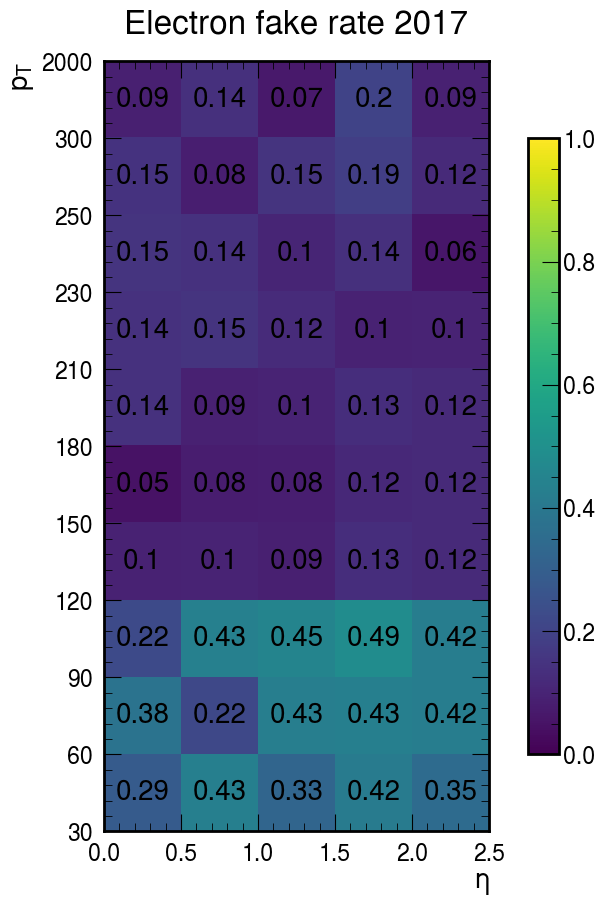

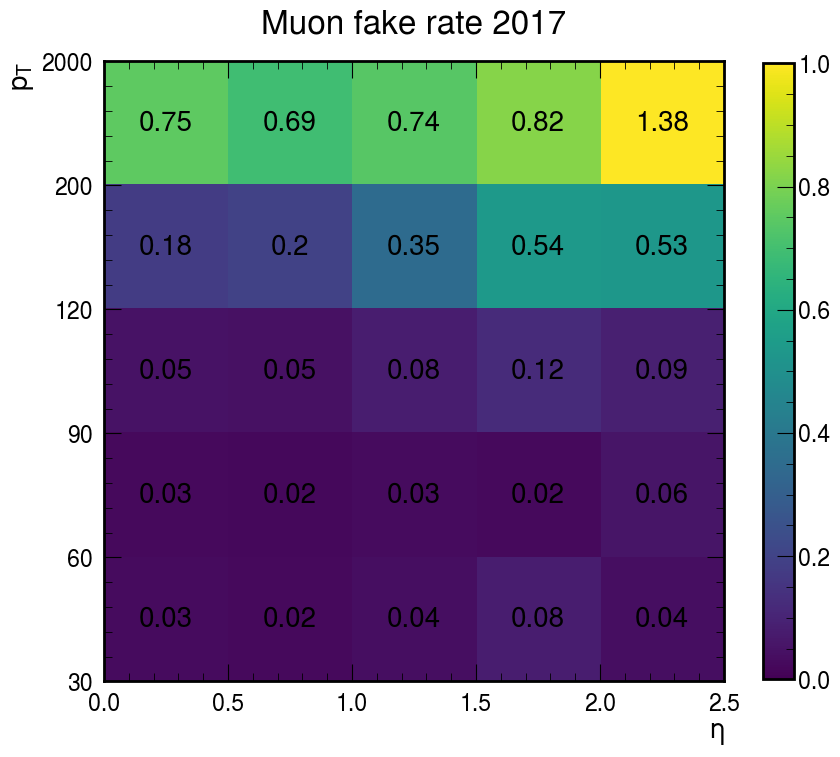

In [121]:
# plot_matrix(FR, region, channels, num=True)
# plot_matrix(FR, region, channels, den=True)
for year in years:
    plot_matrix(FR[year], region, channels)

# Get fake contribution from FR

In [90]:
import scipy
def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [91]:
! ls /Users/fmokhtar/projects/boostedhiggs/eos/May15_uselooselep_2018/

EGamma_Run2018A     EGamma_Run2018C     SingleMuon_Run2018A SingleMuon_Run2018C
EGamma_Run2018B     EGamma_Run2018D     SingleMuon_Run2018B SingleMuon_Run2018D


In [92]:
PR = 0.95

for year in years:
    for ch in channels:
        print(f"{year}, {ch} channel:")
        if ch == "ele":
            if year == "2018":
                l = glob.glob(f"/Users/fmokhtar/projects/boostedhiggs/eos/May15_uselooselep_{year}/EGamma*/outfiles/*_{ch}.parquet")
            else:
                l = glob.glob(f"/Users/fmokhtar/projects/boostedhiggs/eos/May15_uselooselep_{year}/SingleElectron*/outfiles/*_{ch}.parquet")
            
        else:
            l = glob.glob(f"/Users/fmokhtar/projects/boostedhiggs/eos/May15_uselooselep_{year}/SingleMuon*/outfiles/*_{ch}.parquet")
        data = pd.read_parquet(l)

        data["THWW"] = get_finetuned_score(data, "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")

        if ch == "ele":
            Nt0 = (data["n_tight_electrons"]==0)
            Nt1 = (data["n_tight_electrons"]==1)
        else:
            Nt0 = (data["n_tight_muons"]==0)
            Nt1 = (data["n_tight_muons"]==1)

        data["event_weight"] = 1

        for i in range(len(ptbinning[ch])-1):
            high_pt = ptbinning[ch][i]
            low_pt = ptbinning[ch][i+1]

            msk_pt = (data["lep_pt"] >= low_pt) & (data["lep_pt"] < high_pt)

            for j in range(len(etabinning)-1):
                low_eta = etabinning[j]
                high_eta = etabinning[j+1]

                msk_eta = (abs(data["lep_eta"]) >= low_eta) & (abs(data["lep_eta"]) < high_eta)

                data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])
                data["event_weight"][msk_pt & msk_eta & Nt1] = (FR[year][ch][i,j] * (PR-1)) / (PR - FR[year][ch][i,j])   
                
        data.to_parquet(f"fake_{year}_{ch}.parquet")

2016, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.20056767096873662' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2016, mu channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.0402248219075962' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2016APV, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.0774523059183136' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2016APV, mu channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1.8984784548679918' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2017, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.09538117427686185' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2017, mu channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.597433331956137' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2018, ele channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.014116494961406595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


2018, mu channel:


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_64538/1744990406.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.2730674146848697' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data["event_weight"][msk_pt & msk_eta & Nt0] = (PR * FR[year][ch][i,j]) / (PR - FR[year][ch][i,j])


In [93]:
print(f"{nice_ch[ch]} channel 2017")
print(f"Fake contribution before any tagger cuts is {100*data['event_weight'].sum()/len(data):.2f}% of the Data")
print()
# for X in [0.5, 0.8, 0.925]:
#     msk = data["THWW"]>X
#     print(f"After THWW>{X}, Fake contribution is {100*data['event_weight'][msk].sum()/len(data[msk]):.2f}% of the Data")
    
msk = data["THWW"]>0.80
print(f"At pre-selection (THWW>0.80), Fake contribution is {100*data['event_weight'][msk].sum()/len(data[msk]):.2f}% of the Data")    

msk = data["THWW"]>0.925
print(f"In the signal region (THWW>0.92), Fake contribution is {100*data['event_weight'][msk].sum()/len(data[msk]):.2f}% of the Data")

NameError: name 'nice_ch' is not defined

KeyError: 'weight'

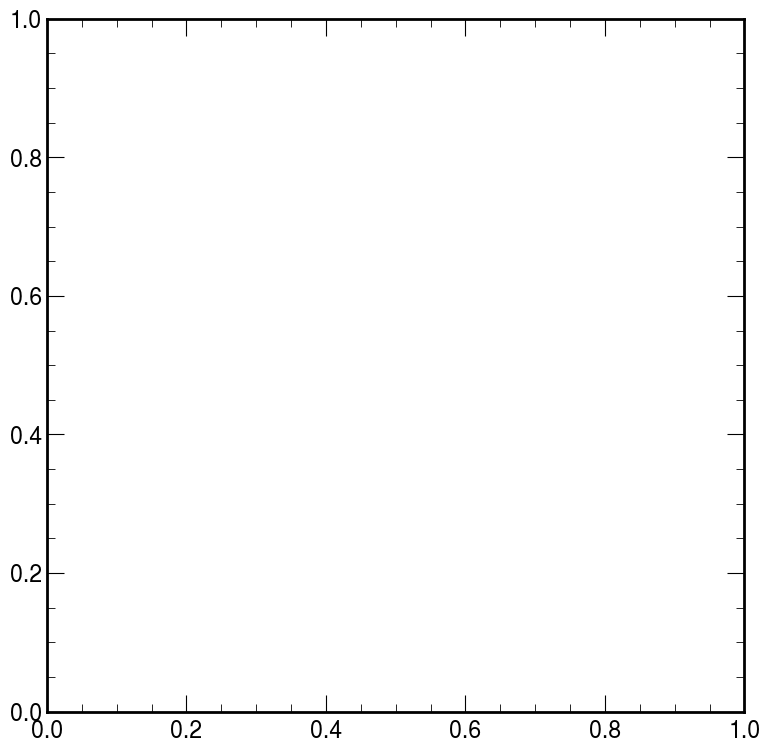

In [37]:
plt.rcParams.update({"font.size": 20})



fig, ax = plt.subplots(figsize=(9, 9))

for tagger_cut in [0.0, 0.5, 0.8, 0.925]:
    msk = data["THWW"]>tagger_cut
    
    x = data['rec_higgs_m'][msk]
    w = data['weight'][msk]
    
    ax.hist(x, bins=list(range(55, 255, 10)), weights=w, label=f"THWW>{tagger_cut}", histtype="step", density=True)


ax.legend(title=f"{nice_ch[ch]} channel")
ax.set_ylabel("Fake events")
ax.set_xlabel("Higgs Reconstructed Mass [GeV]")
ax.set_ylim(0)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/fakes/mass.pdf")

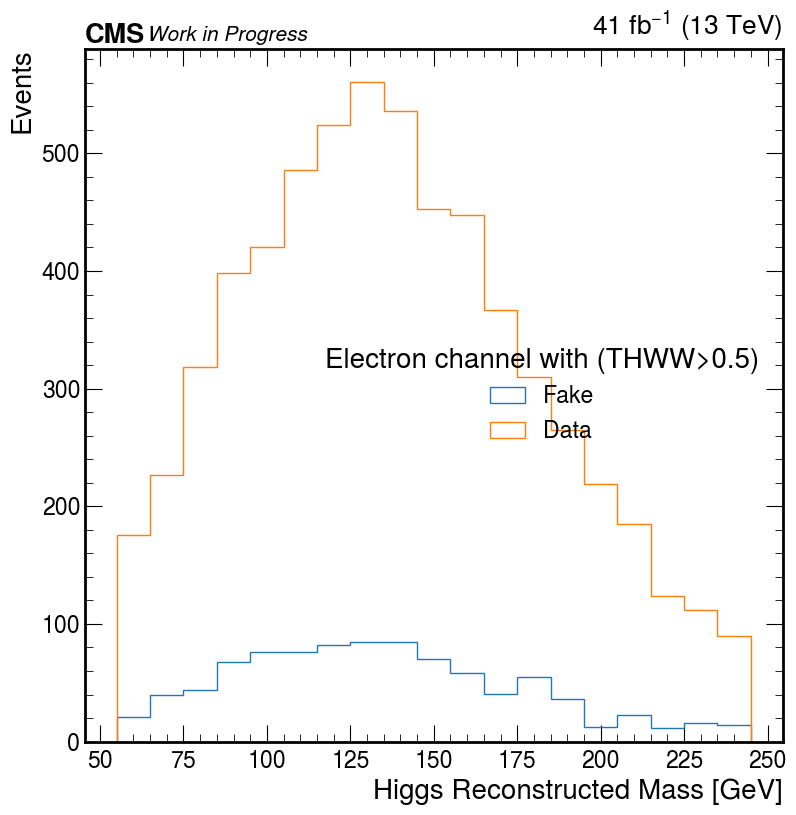

In [645]:
plt.rcParams.update({"font.size": 20})

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

fig, ax = plt.subplots(figsize=(9, 9))

tagger_cut = 0.5

msk = data["THWW"]>tagger_cut

x = data['rec_higgs_m'][msk]
w = data['weight'][msk]

ax.hist(x, bins=list(range(55, 255, 10)), weights=w, label=f"Fake", histtype="step")
ax.hist(x, bins=list(range(55, 255, 10)), label=f"Data", histtype="step")


ax.legend(title=f"{nice_ch[ch]} channel with (THWW>{tagger_cut})")
ax.set_ylabel("Events")
ax.set_xlabel("Higgs Reconstructed Mass [GeV]")
ax.set_ylim(0)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/fakes/masspre.pdf")

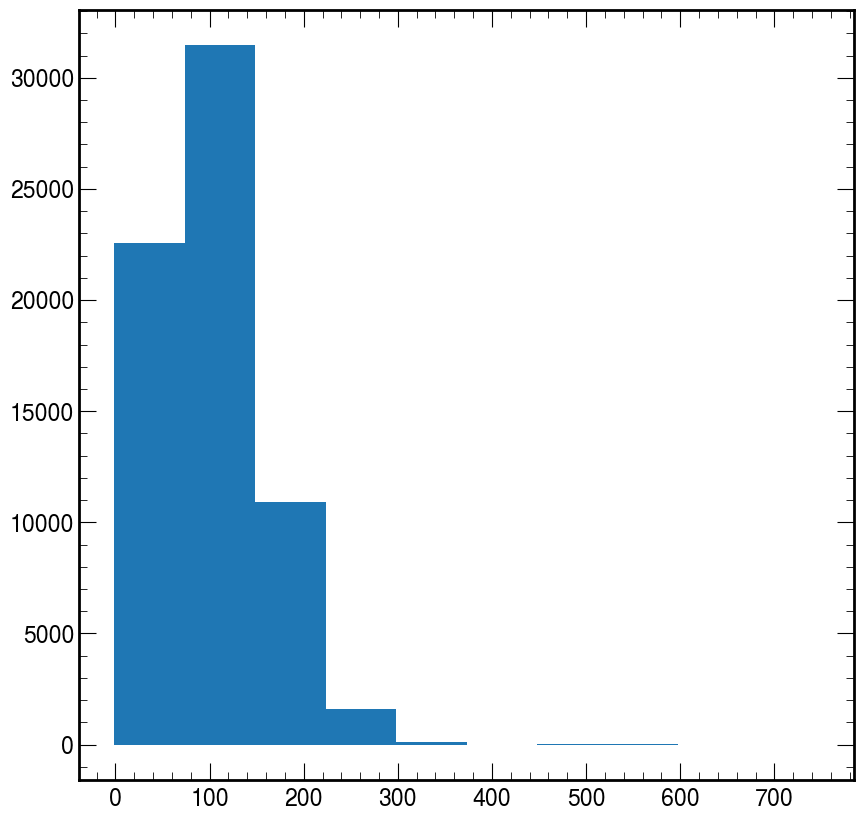

In [180]:
plt.hist(data["rec_higgs_m"], weights=data["weight"]);

# Prompt rate

In [39]:
region = "prompt"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [40]:
# ptbinning = np.flip(np.round(np.linspace(30, 400, 5), 2))
ptbinning = [400, 200, 100, 30]
ptbinning

[400, 200, 100, 30]

In [41]:
etabinning = np.round(np.linspace(0, 2.4, 6),2)
etabinning

array([0.  , 0.48, 0.96, 1.44, 1.92, 2.4 ])

In [42]:
PR = {}
for ch in channels:
    PR[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(PR[ch].shape)

(3, 5)
(3, 5)


In [43]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]["Data"]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt = (df["loose_lep1_pt"] > low_pt) & (df["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta = (df["loose_lep1_eta"] > low_eta) & (df["loose_lep1_eta"] < high_eta)
    
            # get FR
            tight = df["N_tight_lep"][msk_pt & msk_eta].sum()
            loose = df["N_loose_lep"][msk_pt & msk_eta].sum()
            
            PR[ch][i,j] = tight/loose
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {PR[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.48); tight/loose: 0.89
   etabin (0.48, 0.96); tight/loose: 0.88
   etabin (0.96, 1.44); tight/loose: 0.91
   etabin (1.44, 1.92); tight/loose: 0.94
   etabin (1.92, 2.40); tight/loose: 0.87
   ptbin (100.00, 200.00)
   etabin (0.00, 0.48); tight/loose: 0.91
   etabin (0.48, 0.96); tight/loose: 0.90
   etabin (0.96, 1.44); tight/loose: 0.90
   etabin (1.44, 1.92); tight/loose: 0.91
   etabin (1.92, 2.40); tight/loose: 0.89
   ptbin (30.00, 100.00)
   etabin (0.00, 0.48); tight/loose: 0.91
   etabin (0.48, 0.96); tight/loose: 0.91
   etabin (0.96, 1.44); tight/loose: 0.91
   etabin (1.44, 1.92); tight/loose: 0.91
   etabin (1.92, 2.40); tight/loose: 0.90
----------------------------
2017, mu channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.48); tight/loose: 0.98
   etabin (0.48, 0.96); tight/loose: 0.96
   etabin (0.96, 1.44); tight/loose: 0.96
   etabin (1.44, 1.92); tight/loose: 0.98
   etabin (1.92, 2.40); tight/loo

TypeError: list indices must be integers or slices, not str

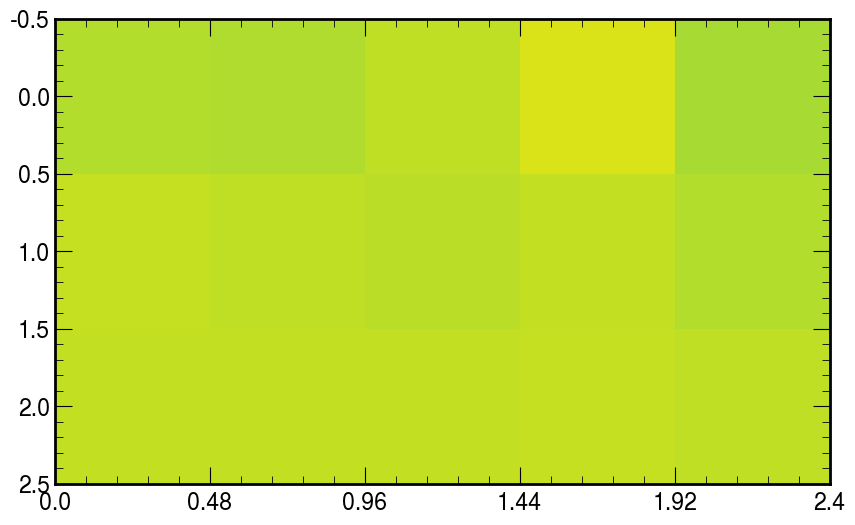

In [44]:
# plot_matrix(PR, region, channels, num=True)
# plot_matrix(PR, region, channels, den=True)
plot_matrix(PR, region, channels)

# SF

In [979]:
region = "prompt"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [980]:
# ptbinning = np.flip(np.round(np.linspace(30, 400, 5), 2))
ptbinning = [400, 200, 100, 30]
ptbinning

[400, 200, 100, 30]

In [981]:
etabinning = np.round(np.linspace(0, 2.4, 4),2)
etabinning

array([0. , 0.8, 1.6, 2.4])

In [982]:
SF = {}
for ch in channels:
    SF[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(SF[ch].shape)

(3, 3)
(3, 3)


In [989]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt_data = (df["Data"]["loose_lep1_pt"] > low_pt) & (df["Data"]["loose_lep1_pt"] < high_pt)
        msk_pt_dyjets = (df["DYJets"]["loose_lep1_pt"] > low_pt) & (df["DYJets"]["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta_data = (df["Data"]["loose_lep1_eta"] > low_eta) & (df["Data"]["loose_lep1_eta"] < high_eta)
            msk_eta_dyjets = (df["DYJets"]["loose_lep1_eta"] > low_eta) & (df["DYJets"]["loose_lep1_eta"] < high_eta)            
    
            # get FR
            loose_data = df["Data"]["N_loose_lep"][msk_pt_data & msk_eta_data].sum()
            loose_dyjets = df["DYJets"]["N_loose_lep"][msk_pt_dyjets & msk_eta_dyjets].sum()
            
            SF[ch][i,j] = loose_data/loose_dyjets
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {SF[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.01
   etabin (0.80, 1.60); tight/loose: 0.01
   etabin (1.60, 2.40); tight/loose: 0.01
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.03
   etabin (0.80, 1.60); tight/loose: 0.03
   etabin (1.60, 2.40); tight/loose: 0.03
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 1.00
   etabin (0.80, 1.60); tight/loose: 0.99
   etabin (1.60, 2.40); tight/loose: 0.95
----------------------------
2017, mu channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.01
   etabin (0.80, 1.60); tight/loose: 0.01
   etabin (1.60, 2.40); tight/loose: 0.01
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.04
   etabin (0.80, 1.60); tight/loose: 0.04
   etabin (1.60, 2.40); tight/loose: 0.04
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 1.30
   etabin (0.80, 1.60); tight/loose: 1.30
   etabin (1.60, 2.40); tight/loose: 1.33
------------------------

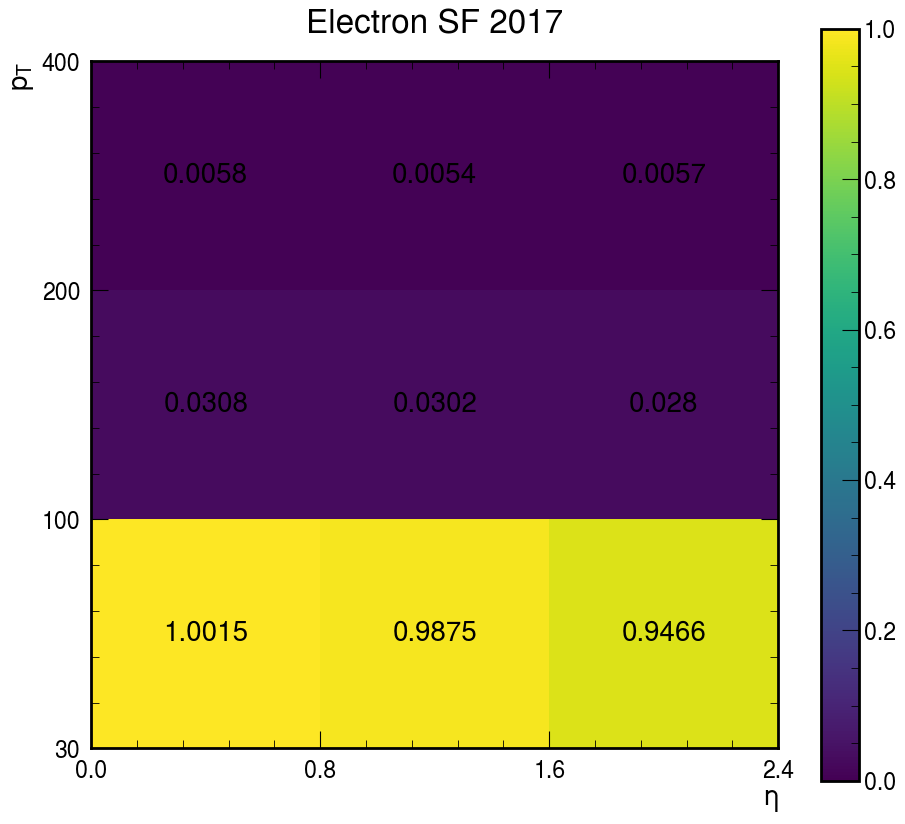

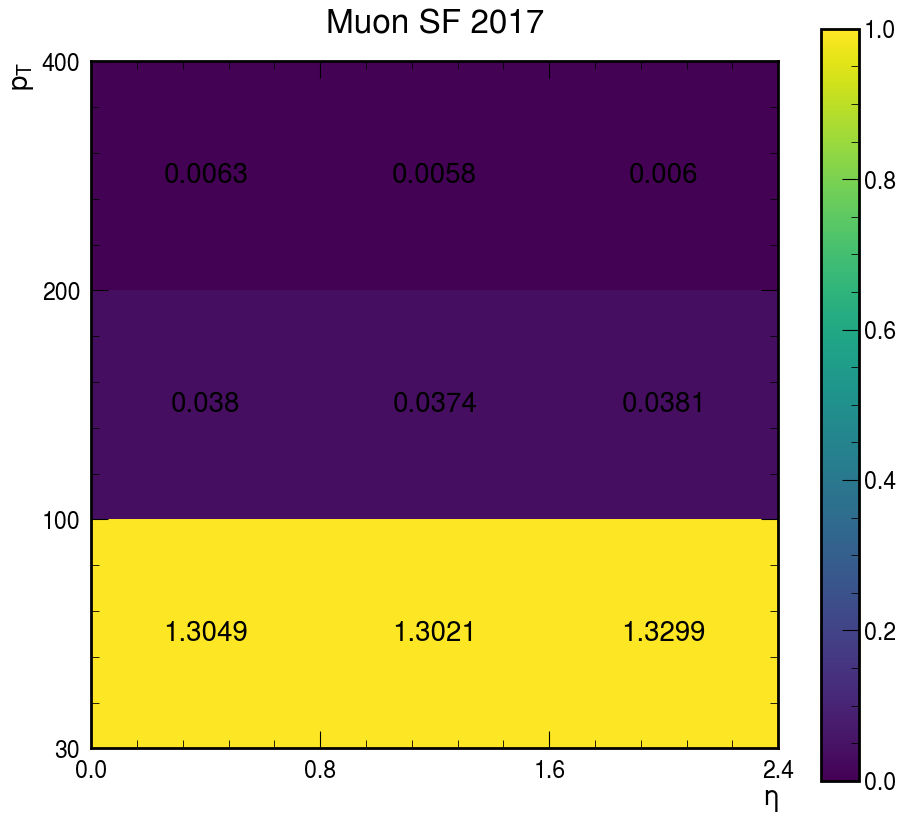

In [990]:
# plot_matrix(SF, "SF", channels, num=True)
# plot_matrix(SF, "SF", channels, den=True)
plot_matrix(SF, "SF", channels)

In [995]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]

    # get FR
    loose_data = df["Data"]["N_loose_lep"].sum()
    loose_dyjets = df["DYJets"]["N_loose_lep"].sum()

    print("SF:", loose_data/loose_dyjets)
    print("----------------------------")

2017, ele channel:
SF: 0.6102147982578899
----------------------------
2017, mu channel:
SF: 0.9580618929762115
----------------------------


# Fake rate extraction (with SF)

In [515]:
region = "fake"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [579]:
ptbinning = np.flip(np.round(np.linspace(30, 400, 5),2))
ptbinning

array([400. , 307.5, 215. , 122.5,  30. ])

In [580]:
etabinning = np.round(np.linspace(0, 2.4, 5),2)
etabinning

array([0. , 0.6, 1.2, 1.8, 2.4])

In [581]:
FR = {}
for ch in channels:
    FR[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(FR[ch].shape)

(4, 4)
(4, 4)


In [582]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]["Data"]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt = (df["loose_lep1_pt"] > low_pt) & (df["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta = (df["loose_lep1_eta"] > low_eta) & (df["loose_lep1_eta"] < high_eta)
    
            # get FR
            tight = df["N_tight_lep"][msk_pt & msk_eta].sum()
            loose = df["N_loose_lep"][msk_pt & msk_eta].sum()
            
            FR[ch][i,j] = tight/loose
            
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {FR[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (307.50, 400.00)
   etabin (0.00, 0.60); tight/loose: 0.89
   etabin (0.60, 1.20); tight/loose: 0.87
   etabin (1.20, 1.80); tight/loose: 0.93
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (215.00, 307.50)
   etabin (0.00, 0.60); tight/loose: 0.89
   etabin (0.60, 1.20); tight/loose: 0.89
   etabin (1.20, 1.80); tight/loose: 0.91
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (122.50, 215.00)
   etabin (0.00, 0.60); tight/loose: 0.91
   etabin (0.60, 1.20); tight/loose: 0.90
   etabin (1.20, 1.80); tight/loose: 0.90
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (30.00, 122.50)
   etabin (0.00, 0.60); tight/loose: 0.91
   etabin (0.60, 1.20); tight/loose: 0.91
   etabin (1.20, 1.80); tight/loose: 0.91
   etabin (1.80, 2.40); tight/loose: 0.91
----------------------------
2017, mu channel:
   ptbin (307.50, 400.00)
   etabin (0.00, 0.60); tight/loose: 0.97
   etabin (0.60, 1.20); tight/loose: 0.95
   etabin (1.20, 1.80); tight/loose: 0.96
   etab

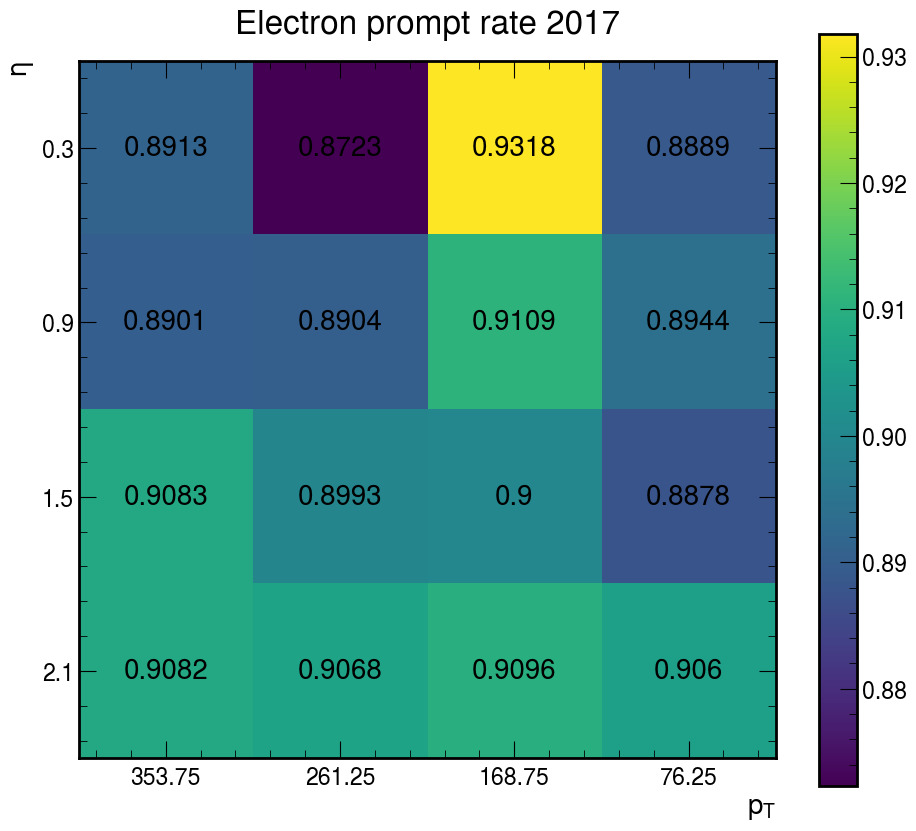

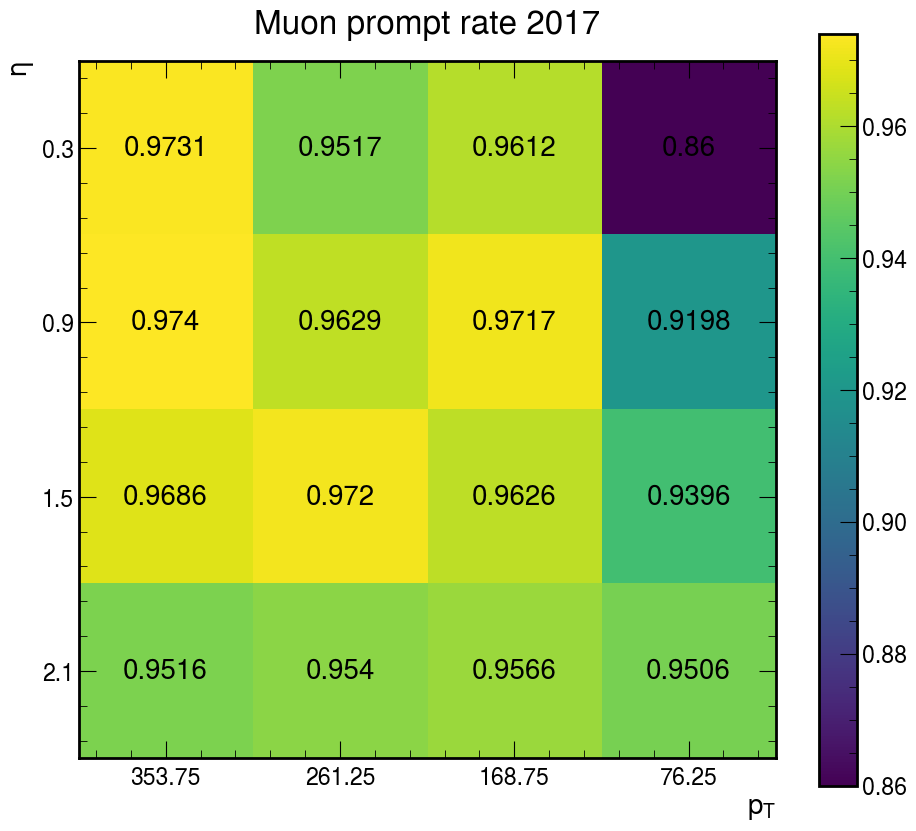

In [583]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(10,10))

    im = ax.imshow(FR[ch])#, cmap='hot', interpolation='nearest')

    ax.set_xticks(ticks=range(FR[ch].shape[0]), labels=np.round(np.convolve(ptbinning, [0.5, 0.5], "valid"),2))
    ax.set_yticks(ticks=range(FR[ch].shape[1]), labels=np.round(np.convolve(etabinning, [0.5, 0.5], "valid"),2))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning)-1):
        for j in range(len(etabinning)-1):
            text = ax.text(j, i, np.round(FR[ch][i, j],4), ha="center", va="center")#, color="w")

    ax.set_xlabel(r"$p_T$")
    ax.set_ylabel(r"$\eta$")

    ax.set_title(set_im_title(year,ch,region), pad=20)

    plt.colorbar(im, shrink=0.8)
    plt.tight_layout()
    
    plt.savefig(f"{PATH}/{year}_{ch}_FR.pdf")

In [ ]:
TOT_FR = FR + 

In [ ]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(10,10))

    im = ax.imshow(SF[ch], vmin=0)#, cmap='hot', interpolation='nearest')

    ax.set_xticks(ticks=range(SF[ch].shape[0]), labels=np.round(np.convolve(ptbinning, [0.5, 0.5], "valid"),2))
    ax.set_yticks(ticks=range(SF[ch].shape[1]), labels=np.round(np.convolve(etabinning, [0.5, 0.5], "valid"),2))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning)-1):
        for j in range(len(etabinning)-1):
            text = ax.text(j, i, np.round(SF[ch][i, j],4), ha="center", va="center")#, color="w")

    ax.set_xlabel(r"$p_T$")
    ax.set_ylabel(r"$\eta$")

    ax.set_title(set_im_title(year,ch,"SF"), pad=20)

    plt.colorbar(im, shrink=0.8)
    plt.tight_layout()
    
    plt.savefig(f"{PATH}/{year}_{ch}_SF.pdf")